# Bigram Association Networks

This tool allows us to view the connections between frequently used words in Tweets, and handily visualize them as a network.

For the purposes of this demo, we will be using some sample Tweets from the Twitter API. I chose to filter tweets pertaining to Tesla, but this choice is obviously arbitrary.

As an analytical tool, this can facilitate a high resolution look at which phrases are commonly associated with specific stocks. It may also be helpful in (informally) understanding general sentiment towards a company.

In order to make this demo work, you will need to have your own credentials for the Twitter API, which I would recommend storing as environment variables locally and accessing using the ***os library*** or by storing them in a ***YAML file*** (note that such a file should not be added to the GitHub unless it is included in the .gitignore), but you can also just copy and paste your keys into the spaces indicated.

In [1]:
import tweepy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import json
from textblob import TextBlob
import re
from nltk import bigrams
from nltk.corpus import stopwords
import networkx as nx
import itertools
import collections

In [ ]:
consumer_key = "xxxxxx" #Add your Twitter API credentials here
consumer_secret = "xxxxxxxxxxxx"
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

## Text Cleaning

One of the most important tasks for this type of project is *cleaning* the incoming data so that it can be properly analyzed. The first things we will want to do is remove any URLs from the Tweets, as they are unncessary and we do not want any active links in the dataset.

We will later work to remove any commonly used words that are important grammatically but do not carry very much lexical importance (e.g., the, that, etc.). NLTK comes with a list of these, so we will use that as a starting point. We will also want to remove any of the words naming the collection we are interested in (read: Tesla). This is because merely naming the subject does not provide any interesting information ***about*** Tweets that concern the company.

In [7]:
def remove_url(txt): 
    #This function removes URLs from the provided text using a regex statement. Don't worry about understainding it. 
    #I barely do.
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [8]:
search_term = "#tesla -filter:retweets" #We want tweets related to tesla

tweets = tweepy.Cursor(api.search, q=search_term, lang='en', since='2020-01-01').items(100) #Find 100 tweets related to Tesla that were posted from 2020-21

tweets_no_urls = [remove_url(tweet.text) for tweet in tweets] #Simple list comprehension to create a list containing url-scraped tweets.

In [9]:
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]
nltk.download('stopwords') #will make sure "stopwords" list is up to date
stop_words = set(stopwords.words('english'))

tweets_nsw = [[word for word in tweet_words if not word in stop_words] for tweet_words in words_in_tweet]

collection_words = ["Tesla", "TSLA", "tesla", "TESLA"] #these are our "Tesla" related words (TSLA is the ticker) that we ignore

tweets_nsw_nc = [[w for w in word if not w in collection_words] for word in tweets_nsw]

[nltk_data] Downloading package stopwords to /Users/nsort/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This next part is a bit complex, but the only important thing to remember is that we are creating a Python dictionary of the bigrams, which then becomes a ***Counter*** object. That is, we then associate each bigram pair, with the *number of times* it occurs in the dataset.

In [10]:
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

bigrams = list(itertools.chain(*terms_bigram))

bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(50),
                             columns=['Bigram', 'Count'])

d = bigram_df.set_index('Bigram').T.to_dict('records')

## Network Representation

This is where the magic really happens. Essentially we take the bigrams and use the count to form a weighted graph, which we visualize using a method that takes advantage of the Fruchterman-Reingold force-directed algorithm, which is amazing in its own right, albeit beyond the scope of this visualization technqiue.

It can be a bit difficult to interpret, but each time you run the code it will give you a slightly different arrangement of the nodes in the box, which may help you find a configuration that is easiest to read.

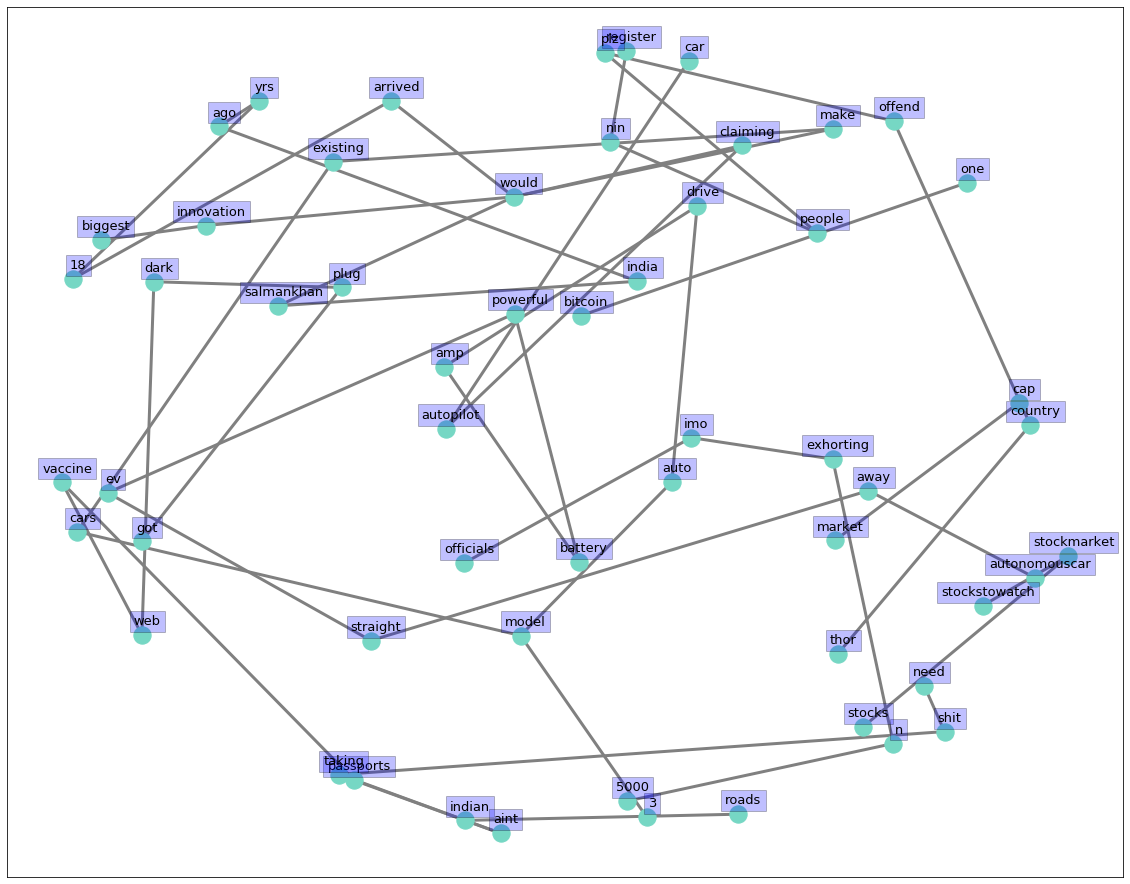

In [18]:
G=nx.Graph()

for k,v in d[0].items():
    G.add_edge(k[0],k[1], weight=(v*10))

fig, ax = plt.subplots(figsize=(20,16))

pos = nx.spring_layout(G, k=2)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='#76D7C4',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.01, value[1]+.025
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='blue', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()